In [1]:
!pip install xgboost catboost scikit-learn pandas matplotlib

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# # AWS S3에서 데이터 load
# url = "https://snu-bigdata-fintech-ai.s3.ap-northeast-2.amazonaws.com/data/interim/preprocessed_data.csv"
# df = pd.read_csv(url)
# df.head()

In [28]:
pd.set_option('display.max_columns', None)  # 열 생략 없이 보기
pd.set_option('display.max_rows', None)     # 행 생략 없이 보기
pd.set_option('display.max_colwidth', None) # 컬럼 너비 제한 해제

df = pd.read_csv("../data/interim/preprocessed_data.csv", low_memory = False)
df.head()

,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,grade_num,sub_grade_num,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,application_type_Individual,application_type_Joint App,application_type_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,emp_length_missing,percent_bc_gt_75_missing,grade_num_missing,max_bal_bc_missing,mths_since_recent_inq_missing,il_util_missing,inq_last_6mths_missing,delinq_2yrs_missing,acc_now_delinq_missing,open_rv_24m_missing,open_acc_missing,total_bal_il_missing,open_il_12m_missing,open_rv_12m_missing,all_util_missing,mths_since_last_delinq_missing,mths_since_rcnt_il_missing,inq_last_12m_missing,delinq_amnt_missing,mths_since_recent_revol_delinq_missing,open_il_24m_missing,last_fico_range_low_missing,sub_grade_num_missing,annual_inc_missing,open_act_il_missing,open_acc_6m_missing,last_fico_range_high_missing,total_acc_missing,fico_range_low_missing,pub_rec_missing,revol_bal_missing,fico_range_high_missing
0,2.0,45000.0,8.67,1.0,755.0,759.0,0.0,22.0,14.0,0.0,3090.0,14.0,36.0,764.0,760.0,0.0,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,110000.0,34.70,1.0,670.0,674.0,1.0,10.0,24.0,0.0,16909.0,55.9,60.0,639.0,635.0,0.0,0.0,0.0,6

In [29]:
# 데이터 준비
df = df[df['default'].notnull()]
features = [col for col in df.columns if col != 'default']
X = df[features]
y = df['default']

# 데이터 3-way split: train, val, test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42, stratify=y_train_temp
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (108788, 182), Validation: (36263, 182), Test: (36263, 182)


In [30]:
# 3. 공통 모델 학습/평가 함수
def fit_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, bar_color, cmap):
    model.fit(X_train, y_train)
    
    # --- Validation (threshold=0.5)
    y_pred_val = model.predict(X_val)
    y_proba_val = model.predict_proba(X_val)[:, 1]

    print(f'\n{model_name} [Validation] Classification Report (Threshold=0.5):')
    print(classification_report(y_val, y_pred_val))
    print(f'{model_name} [Validation] ROC-AUC:', roc_auc_score(y_val, y_proba_val))

    # --- Feature Importance (상위 10개)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    top_features = X_train.columns[indices]
    plt.figure(figsize=(8, 5))
    plt.barh(top_features[::-1], importances[indices][::-1], color=bar_color)
    plt.title(f'{model_name} Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # --- ROC Curve (Validation)
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_proba_val)
    roc_auc_val = auc(fpr_val, tpr_val)

    # --- 최적 임계값(Validation, Youden's J 기준)
    J = tpr_val - fpr_val
    ix = np.argmax(J)
    best_thresh = thresholds_val[ix]
    print(f"{model_name} [Validation] 최적 임계값 (Youden's J): {best_thresh:.3f}")

    # --- Test Set: 임계값 0.5
    y_proba_test = model.predict_proba(X_test)[:, 1]
    y_pred_test_05 = (y_proba_test >= 0.5).astype(int)
    print(f'\n{model_name} [Test] Classification Report (Threshold=0.5):')
    print(classification_report(y_test, y_pred_test_05))
    print(f'{model_name} [Test] ROC-AUC:', roc_auc_score(y_test, y_proba_test))
    cm_test_05 = confusion_matrix(y_test, y_pred_test_05)
    disp_test_05 = ConfusionMatrixDisplay(confusion_matrix=cm_test_05)
    disp_test_05.plot(cmap=cmap)
    plt.title(f'Confusion Matrix ({model_name} Test - Threshold=0.5)')
    plt.show()
    tn, fp, fn, tp = cm_test_05.ravel()
    print(f"[{model_name} Test - Threshold=0.5] TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

    # --- Test Set: 최적 임계값
    y_pred_test_opt = (y_proba_test >= best_thresh).astype(int)
    print(f'\n{model_name} [Test] Classification Report (최적 임계값={best_thresh:.3f}):')
    print(classification_report(y_test, y_pred_test_opt))
    print(f'{model_name} [Test] ROC-AUC:', roc_auc_score(y_test, y_proba_test))
    cm_test_opt = confusion_matrix(y_test, y_pred_test_opt)
    disp_test_opt = ConfusionMatrixDisplay(confusion_matrix=cm_test_opt)
    disp_test_opt.plot(cmap=cmap)
    plt.title(f'Confusion Matrix ({model_name} Test - Optimal Threshold={best_thresh:.3f})')
    plt.show()
    tn_opt, fp_opt, fn_opt, tp_opt = cm_test_opt.ravel()
    print(f"[{model_name} Test - Optimal Threshold={best_thresh:.3f}] TN: {tn_opt}, FP: {fp_opt}, FN: {fn_opt}, TP: {tp_opt}")

    # --- ROC Curve (Test)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    return fpr_test, tpr_test, roc_auc_test, best_thresh

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:23:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost [Validation] Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     29198
         1.0       0.74      0.72      0.73      7065

    accuracy                           0.90     36263
   macro avg       0.84      0.83      0.83     36263
weighted avg       0.90      0.90      0.90     36263

XGBoost [Validation] ROC-AUC: 0.9420314637300532


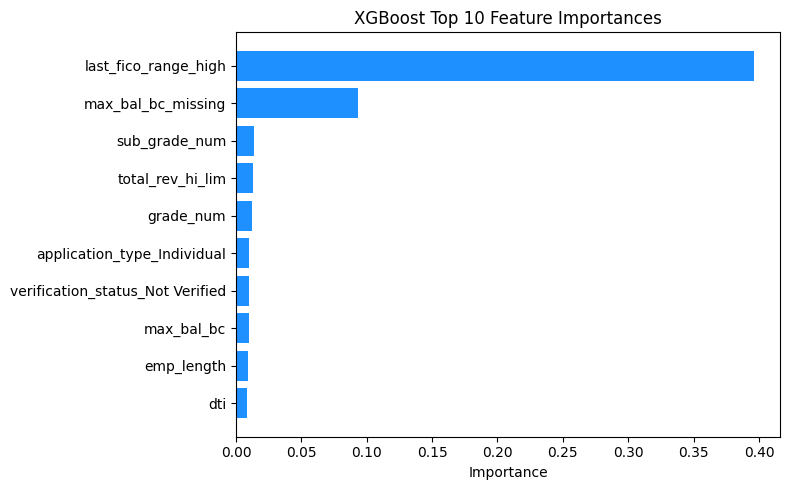

XGBoost [Validation] 최적 임계값 (Youden's J): 0.179

XGBoost [Test] Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     29198
         1.0       0.74      0.73      0.73      7065

    accuracy                           0.90     36263
   macro avg       0.84      0.83      0.83     36263
weighted avg       0.90      0.90      0.90     36263

XGBoost [Test] ROC-AUC: 0.9431378832479728


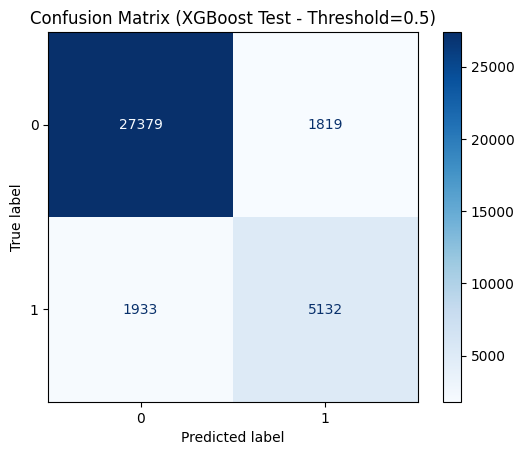

[XGBoost Test - Threshold=0.5] TN: 27379, FP: 1819, FN: 1933, TP: 5132

XGBoost [Test] Classification Report (최적 임계값=0.179):
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     29198
         1.0       0.60      0.92      0.73      7065

    accuracy                           0.86     36263
   macro avg       0.79      0.89      0.82     36263
weighted avg       0.90      0.86      0.87     36263

XGBoost [Test] ROC-AUC: 0.9431378832479728


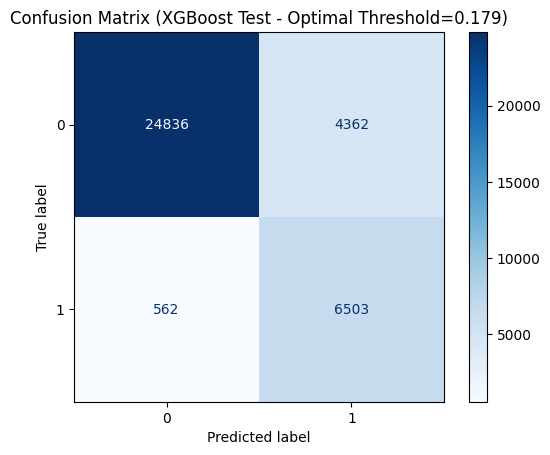

[XGBoost Test - Optimal Threshold=0.179] TN: 24836, FP: 4362, FN: 562, TP: 6503


In [31]:
# 4. XGBoost
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
fpr_xgb, tpr_xgb, auc_xgb, thresh_xgb = fit_and_evaluate(
    xgb, X_train, y_train, X_val, y_val, X_test, y_test, 'XGBoost', 'dodgerblue', 'Blues'
)


CatBoost [Validation] Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     29198
         1.0       0.74      0.73      0.73      7065

    accuracy                           0.90     36263
   macro avg       0.84      0.83      0.84     36263
weighted avg       0.90      0.90      0.90     36263

CatBoost [Validation] ROC-AUC: 0.9412091987609114


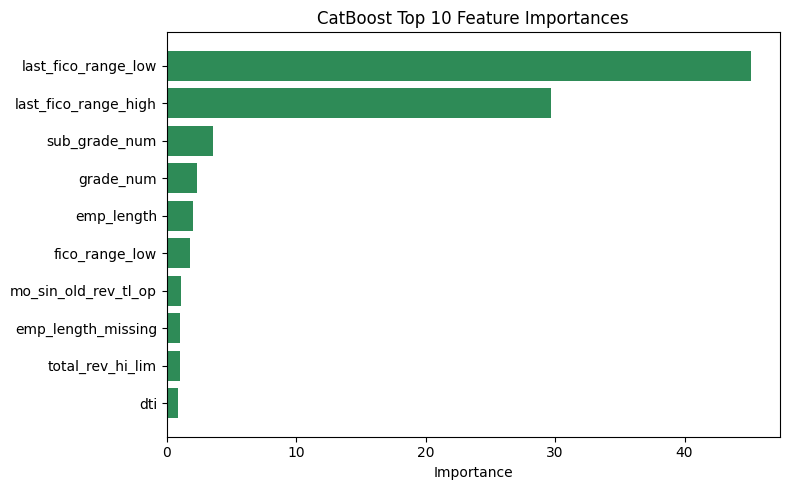

CatBoost [Validation] 최적 임계값 (Youden's J): 0.177

CatBoost [Test] Classification Report (Threshold=0.5):
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     29198
         1.0       0.73      0.73      0.73      7065

    accuracy                           0.90     36263
   macro avg       0.83      0.83      0.83     36263
weighted avg       0.90      0.90      0.90     36263

CatBoost [Test] ROC-AUC: 0.9420314976638747


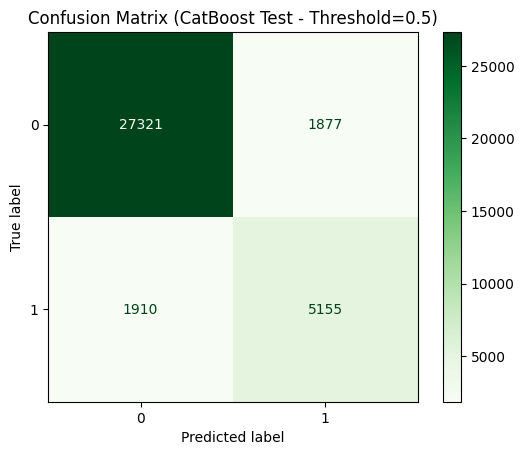

[CatBoost Test - Threshold=0.5] TN: 27321, FP: 1877, FN: 1910, TP: 5155

CatBoost [Test] Classification Report (최적 임계값=0.177):
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     29198
         1.0       0.59      0.92      0.72      7065

    accuracy                           0.86     36263
   macro avg       0.79      0.88      0.81     36263
weighted avg       0.90      0.86      0.87     36263

CatBoost [Test] ROC-AUC: 0.9420314976638747


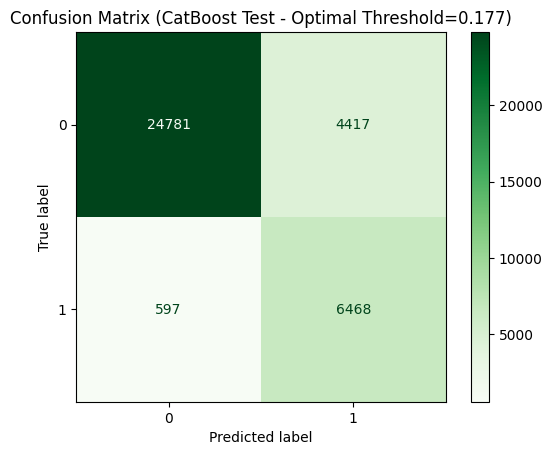

[CatBoost Test - Optimal Threshold=0.177] TN: 24781, FP: 4417, FN: 597, TP: 6468


In [32]:
# 5. CatBoost
cat = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, verbose=0)
fpr_cat, tpr_cat, auc_cat, thresh_cat = fit_and_evaluate(
    cat, X_train, y_train, X_val, y_val, X_test, y_test, 'CatBoost', 'seagreen', 'Greens'
)

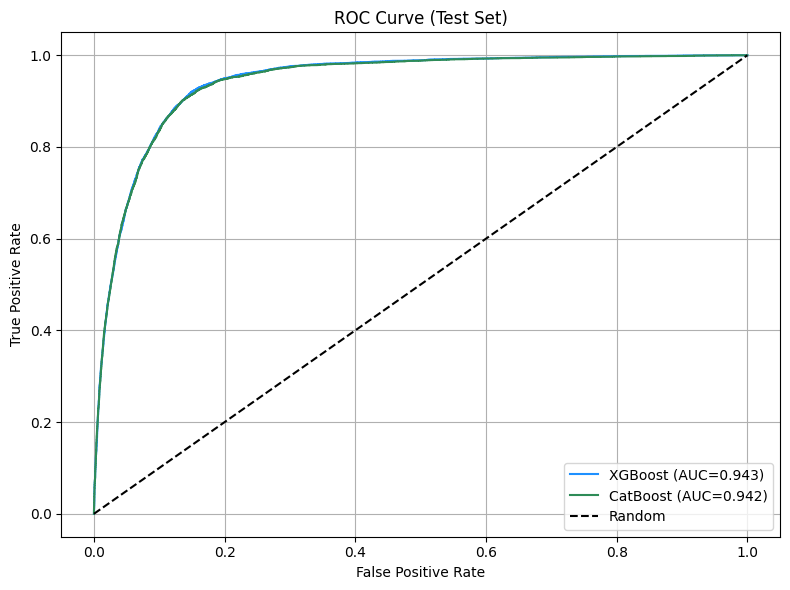

In [33]:
# ROC Curve 한 번에 (Test 기준)
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})', color='dodgerblue')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC={auc_cat:.3f})', color='seagreen')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
pd.set_option('display.max_columns', None)  # 열 생략 없이 보기
pd.set_option('display.max_rows', None)     # 행 생략 없이 보기
pd.set_option('display.max_colwidth', None) # 컬럼 너비 제한 해제

df = pd.read_csv("../data/interim/preprocessed_data_ver.2.2.(IRR+LOG+BINARY).csv", low_memory = False)
df.head()

,funded_amnt,term,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,funded_amnt_missing,delinq_amnt_missing,inq_last_12m_missing,fico_range_low_missing,mths_since_last_delinq_missing,all_util_missing,collection_recovery_fee_missing,fico_range_high_missing,open_act_il_missing,mths_since_recent_revol_delinq_missing,delinq_2yrs_missing,annual_inc_missing,pub_rec_missing,open_acc_6m_missing,recoveries_missing,total_acc_missing,mths_since_recent_inq_missing,open_acc_missing,last_fico_range_high_missing,mths_since_rcnt_il_missing,open_rv_24m_missing,revol_bal_missing,total_bal_il_missing,inq_last_6mths_missing,open_il_12m_missing,max_bal_bc_missing,il_util_missing,acc_now_delinq_missing,installment_missing,open_il_24m_missing,open_rv_12m_missing
0,6000.0,36,187.94,2.0,10.714440,2.269028,1,755.0,759.0,0.0,22.0,14.0,0,8.036250,14.0,36.0,0.00,0.000,Apr-2020,764.0,0,0,0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,8.036250,64.0,10.003378,2.0,4.0,8.256088,9.385218,20.6,0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0,0,0,4.0,97.1,0.0,0,0,11.272280,10.820878,9.615872,10.942208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23200.0,60,680.82,10.0,11.608245,3.575151,1,670.0,674.0,1.0,10.0,24.0,0,9.735660,55.9,60.0,5260.00,946.800,Dec-2016,639.0,0,0,0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,8.455105,85.0,10.317450,7.0,8.0,10.137175,8.702012,70.4,0,0.0,126.0,277.0,6.0,6.0,2.0,7.0,0.0,10.0,0.0,10.0,8.0,14.0,36.0,12.0,22.0,10.0,24.0,0,0,0,5.0,94.8,37.5,0,0,13.386134,12.592905,9.918425,12.582679,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import numpy as np
import pandas as pd

import xgboost as xgb
from catboost import CatBoostClassifier

# 드롭할 컬럼 (기존과 동일)
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default'
]

X = df.drop(columns=drop_cols)
y = df['default']

# 결과 저장용 리스트 (XGBoost)
xgb_val_auc_list, xgb_val_acc_list = [], []
xgb_test_auc_list, xgb_test_acc_list = [], []
xgb_pred_dfs = []

# 결과 저장용 리스트 (CatBoost)
cat_val_auc_list, cat_val_acc_list = [], []
cat_test_auc_list, cat_test_acc_list = [], []
cat_pred_dfs = []

for seed in tqdm(range(5), desc="XGBoost & CatBoost 5회 반복"):

    # 데이터 분할
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=seed)

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

    # ---------------- XGBoost ----------------
    model_xgb = xgb.XGBClassifier(
        n_estimators=100, learning_rate=0.1, use_label_encoder=False,
        eval_metric='logloss', random_state=seed, n_jobs=-1
    )
    model_xgb.fit(X_train, y_train)

    y_val_prob = model_xgb.predict_proba(X_val)[:, 1]
    y_val_pred = model_xgb.predict(X_val)

    xgb_val_auc_list.append(roc_auc_score(y_val, y_val_prob))
    xgb_val_acc_list.append(accuracy_score(y_val, y_val_pred))

    y_test_prob = model_xgb.predict_proba(X_test)[:, 1]
    y_test_pred = model_xgb.predict(X_test)

    xgb_test_auc_list.append(roc_auc_score(y_test, y_test_prob))
    xgb_test_acc_list.append(accuracy_score(y_test, y_test_pred))

    pred_df = X_test.copy()
    pred_df['default'] = y_test.values
    pred_df['original_index'] = X_test.index
    pred_df['pred_prob'] = y_test_prob
    pred_df['pred'] = y_test_pred
    xgb_pred_dfs.append(pred_df)

    # ---------------- CatBoost ----------------
    model_cat = CatBoostClassifier(
        iterations=100, learning_rate=0.1, depth=6,
        random_seed=seed, verbose=0
    )
    model_cat.fit(X_train, y_train)

    y_val_prob = model_cat.predict_proba(X_val)[:, 1]
    y_val_pred = model_cat.predict(X_val)

    cat_val_auc_list.append(roc_auc_score(y_val, y_val_prob))
    cat_val_acc_list.append(accuracy_score(y_val, y_val_pred))

    y_test_prob = model_cat.predict_proba(X_test)[:, 1]
    y_test_pred = model_cat.predict(X_test)

    cat_test_auc_list.append(roc_auc_score(y_test, y_test_prob))
    cat_test_acc_list.append(accuracy_score(y_test, y_test_pred))


    pred_df = X_test.copy()
    pred_df['default'] = y_test.values
    pred_df['original_index'] = X_test.index
    pred_df['pred_prob'] = y_test_prob
    pred_df['pred'] = y_test_pred
    cat_pred_dfs.append(pred_df)

# ---------------- 결과 요약 출력 ----------------
print("\n[XGBoost] 검증 성능 요약")
print(f"Val AUC 평균: {np.mean(xgb_val_auc_list):.4f} ± {np.std(xgb_val_auc_list):.4f}")
print(f"Val ACC 평균: {np.mean(xgb_val_acc_list):.4f} ± {np.std(xgb_val_acc_list):.4f}")
print("\n[XGBoost] 테스트 성능 요약")
print(f"Test AUC 평균: {np.mean(xgb_test_auc_list):.4f} ± {np.std(xgb_test_auc_list):.4f}")
print(f"Test ACC 평균: {np.mean(xgb_test_acc_list):.4f} ± {np.std(xgb_test_acc_list):.4f}")

print("\n[CatBoost] 검증 성능 요약")
print(f"Val AUC 평균: {np.mean(cat_val_auc_list):.4f} ± {np.std(cat_val_auc_list):.4f}")
print(f"Val ACC 평균: {np.mean(cat_val_acc_list):.4f} ± {np.std(cat_val_acc_list):.4f}")
print("\n[CatBoost] 테스트 성능 요약")
print(f"Test AUC 평균: {np.mean(cat_test_auc_list):.4f} ± {np.std(cat_test_auc_list):.4f}")
print(f"Test ACC 평균: {np.mean(cat_test_acc_list):.4f} ± {np.std(cat_test_acc_list):.4f}")

XGBoost & CatBoost 5회 반복:   0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost & CatBoost 5회 반복:  20%|██        | 1/5 [00:10<00:43, 10.97s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost & CatBoost 5회 반복:  40%|████      | 2/5 [00:22<00:33, 11.20s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [04:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_labe


[XGBoost] 검증 성능 요약
Val AUC 평균: 0.9412 ± 0.0004
Val ACC 평균: 0.8953 ± 0.0004

[XGBoost] 테스트 성능 요약
Test AUC 평균: 0.9416 ± 0.0004
Test ACC 평균: 0.8955 ± 0.0007

[CatBoost] 검증 성능 요약
Val AUC 평균: 0.9403 ± 0.0004
Val ACC 평균: 0.8947 ± 0.0004

[CatBoost] 테스트 성능 요약
Test AUC 평균: 0.9407 ± 0.0004
Test ACC 평균: 0.8952 ± 0.0006


In [4]:
# 전체 예측 결과 통합
xgb_pred_all = pd.concat(xgb_pred_dfs, ignore_index=True)
# cat_pred_all = pd.concat(cat_pred_dfs, ignore_index=True)

# 병합할 원본 정보 (부도 확률 기반 수익률 계산에 필요)
cols_needed = ['term', 'installment', 'funded_amnt', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d']
xgb_pred_all = xgb_pred_all.merge(df[cols_needed], left_on='original_index', right_index=True, how='left')
# cat_pred_all = cat_pred_all.merge(df[cols_needed], left_on='original_index', right_index=True, how='left')

In [5]:
# 전체 예측 결과 통합
xgb_pred_all = pd.concat(xgb_pred_dfs, ignore_index=True)
# cat_pred_all = pd.concat(cat_pred_dfs, ignore_index=True)

# 병합할 원본 정보
cols_needed = ['term', 'installment', 'funded_amnt', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d']

xgb_pred_all = xgb_pred_all.merge(df[cols_needed], left_on='original_index', right_index=True, how='left')
# cat_pred_all = cat_pred_all.merge(df[cols_needed], left_on='original_index', right_index=True, how='left')

# ✅ 병합 정확성 확인
xgb_check = df.loc[xgb_pred_all['original_index'], 'funded_amnt'].reset_index(drop=True) == xgb_pred_all['funded_amnt']
# cat_check = df.loc[cat_pred_all['original_index'], 'funded_amnt'].reset_index(drop=True) == cat_pred_all['funded_amnt']

print(f"[XGBoost] funded_amnt 일치 비율: {xgb_check.mean():.4f}")
# print(f"[CatBoost] funded_amnt 일치 비율: {cat_check.mean():.4f}")

[XGBoost] funded_amnt 일치 비율: 1.0000


In [6]:
!pip install fredapi

In [15]:
from fredapi import Fred
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import os

# 1. FRED API 연결
def connect_fred_api():
    return Fred(api_key='cf9af68d31c1d6b0bcb90e0a95dd532c')  # 환경변수에서 API 키 불러오기

# 2. 3년/5년 금리 시계열 불러오기
def load_risk_free_series():
    fred = connect_fred_api()
    rate_series_3y = fred.get_series('GS3')
    rate_series_5y = fred.get_series('GS5')
    return rate_series_3y, rate_series_5y

# 3. last_pymnt_d와 term으로 issue_d 추정
def estimate_issue_d(last_pymnt_d, term):
    if pd.isnull(last_pymnt_d) or pd.isnull(term):
        return np.nan
    try:
        last_date = pd.to_datetime(last_pymnt_d)
        return last_date - relativedelta(months=int(term))
    except:
        return np.nan

# 4. 추정된 날짜에 가장 가까운 금리 적용
def fetch_risk_free_rate(estimated_issue_d, term, rate_series_3y, rate_series_5y):
    if pd.isnull(estimated_issue_d) or pd.isnull(term):
        return np.nan

    if term == 36:
        target_series = rate_series_3y
    elif term == 60:
        target_series = rate_series_5y
    else:
        return np.nan

    try:
        idx = target_series.index.get_indexer([estimated_issue_d], method='nearest')[0]
        return target_series.iloc[idx] / 100
    except Exception as e:
        print(f"Error fetching rate for {estimated_issue_d}: {e}")
        return np.nan

# 5. 전체 데이터프레임에 적용
def apply_estimated_risk_free_rate(df):
    rate_series_3y, rate_series_5y = load_risk_free_series()

    # issue_d 추정
    df['estimated_issue_d'] = df.apply(lambda x: estimate_issue_d(x['last_pymnt_d'], x['term']), axis=1)

    # 금리 적용
    df['risk_free_rate'] = df.apply(
        lambda x: fetch_risk_free_rate(x['estimated_issue_d'], x['term'], rate_series_3y, rate_series_5y),
        axis=1
    )

    return df


In [16]:
# 금리 시계열 불러오기
rate_series_3y, rate_series_5y = load_risk_free_series()

# estimated_issue_d 컬럼 생성 (last_pymnt_d와 term 기반)
xgb_pred_all['estimated_issue_d'] = xgb_pred_all.apply(
    lambda x: estimate_issue_d(x['last_pymnt_d'], x['term']),
    axis=1
)

# # estimated_issue_d 컬럼 생성 (last_pymnt_d와 term 기반)
# cat_pred_all['estimated_issue_d'] = cat_pred_all.apply(
#     lambda x: estimate_issue_d(x['last_pymnt_d'], x['term']),
#     axis=1
# )

# 추정된 issue_d로부터 금리 시계열 적용
xgb_pred_all = apply_estimated_risk_free_rate(xgb_pred_all)
# cat_pred_all = apply_estimated_risk_free_rate(cat_pred_all)



In [17]:
def calculate_last_pymnt_num(row):
    try:
        last_date = pd.to_datetime(row['last_pymnt_d'])
        issue_d = row.get('estimated_issue_d') or row.get('issue_d')  # estimated_issue_d 우선
        if pd.isnull(issue_d):
            return np.nan
        issue_date = pd.to_datetime(issue_d)
        delta = (last_date.year - issue_date.year) * 12 + (last_date.month - issue_date.month)
        return max(delta, 0)
    except:
        return np.nan


In [18]:
# 적용
xgb_pred_all['last_pymnt_num'] = xgb_pred_all.apply(calculate_last_pymnt_num, axis=1)
# cat_pred_all['last_pymnt_num'] = cat_pred_all.apply(calculate_last_pymnt_num, axis=1)


In [19]:
# 현금흐름 계산 함수
def create_cash_flow(row):
    loan_amnt = row['funded_amnt']  # funded_amnt 사용
    installment = row['installment']
    term = int(row['term'])
    default = row['default']
    last_pymnt_num = row['last_pymnt_num']
    recoveries = row['recoveries']
    collection_recovery_fee = row['collection_recovery_fee']

    # 기본 현금 흐름 시작: 대출금 지출
    cash_flow = [-loan_amnt]
    for month in range(1, term + 1):
        if default == 1:
            if month == last_pymnt_num + 1:
                cash_flow.append(recoveries - collection_recovery_fee)
            elif month <= last_pymnt_num:
                cash_flow.append(installment)
            else:
                cash_flow.append(0)
        else:
            cash_flow.append(installment)

    return cash_flow


# 2. 캐시 저장 및 계산 함수
cash_flow_cache = {}

def get_cash_flow(row):
    # 필수 컬럼들
    required_cols = ['funded_amnt', 'installment', 'term', 'default',
                     'last_pymnt_num', 'recoveries', 'collection_recovery_fee']

    # 필수 값 누락 시 NaN 반환
    if row[required_cols].isnull().any():
        return np.nan

    try:
        key = (
            float(row['funded_amnt']),
            float(row['installment']),
            int(row['term']),
            int(row['default']),
            int(row['last_pymnt_num']),
            float(row['recoveries']),
            float(row['collection_recovery_fee'])
        )
    except Exception as e:
        print(f"[캐시 키 생성 오류] index={row.name} ▶ {e}")
        return np.nan

    if key not in cash_flow_cache:
        cash_flow_cache[key] = create_cash_flow(row)

    return cash_flow_cache[key]


In [20]:
# 캐시 플로우 계산 적용
xgb_pred_all['cash_flow'] = xgb_pred_all.apply(get_cash_flow, axis=1)
# cat_pred_all['cash_flow'] = cat_pred_all.apply(get_cash_flow, axis=1)


In [21]:
!pip install numpy-financial

In [22]:
import numpy as np
import numpy_financial as npf

# IRR 함수 정의
def calculate_irr(cash_flow):
    irr_monthly = npf.irr(cash_flow)
    if irr_monthly is not None and not np.isnan(irr_monthly):
        return (1 + irr_monthly) ** 12 - 1
    else:
        return np.nan

# 캐시 기반 IRR
irr_cache = {}
def get_irr(cash_flow):
    if not isinstance(cash_flow, list) or len(cash_flow) == 0:
        return np.nan
    key = tuple(round(v, 6) for v in cash_flow)
    if key not in irr_cache:
        irr_cache[key] = calculate_irr(cash_flow)
    return irr_cache[key]

# 적용
xgb_pred_all['irr'] = xgb_pred_all['cash_flow'].apply(get_irr)
# cat_pred_all['irr'] = cat_pred_all['cash_flow'].apply(get_irr)

# IRR 누락된 경우는 risk-free rate로 대체
xgb_pred_all['irr'] = xgb_pred_all['irr'].fillna(xgb_pred_all['risk_free_rate'])
# cat_pred_all['irr'] = cat_pred_all['irr'].fillna(cat_pred_all['risk_free_rate'])


In [23]:
def calculate_sharpe(returns, risk_free):
    returns = np.asarray(returns, dtype=float)
    risk_free = np.asarray(risk_free, dtype=float)
    mask = ~np.isnan(returns) & ~np.isnan(risk_free)
    excess = returns[mask] - risk_free[mask]
    if excess.size == 0 or np.nanstd(returns, ddof=1) == 0:
        return np.nan
    return np.nanmean(excess) / np.nanstd(excess, ddof=1)

def compute_sharpe_for_threshold(df, threshold):
    selected = df[df['pred_prob'] <= threshold]
    return calculate_sharpe(selected['irr'], selected['risk_free_rate'])

def find_best_threshold(df, thresholds=np.arange(0.1, 1.01, 0.01)):
    results = []
    for t in thresholds:
        sr = compute_sharpe_for_threshold(df, t)
        results.append((t, sr))
    results = sorted(results, key=lambda x: -x[1] if not np.isnan(x[1]) else -np.inf)
    best_t, best_sr = results[0]
    return best_t, best_sr, results


In [24]:
xgb_sharpe = calculate_sharpe(xgb_pred_all['irr'], xgb_pred_all['risk_free_rate'])
# cat_sharpe = calculate_sharpe(cat_pred_all['irr'], cat_pred_all['risk_free_rate'])
print(f"[XGBOOST]전체 Sharpe Ratio: {xgb_sharpe:.4f}")
# print(f"[XGBOOST]전체 Sharpe Ratio: {cat_sharpe:.4f}")

[XGBOOST]전체 Sharpe Ratio: 2.3755


In [25]:
def compute_sharpe_for_threshold(df, threshold):
    selected = df[df['pred_prob'] <= threshold]
    return calculate_sharpe(selected['irr'], selected['risk_free_rate'])

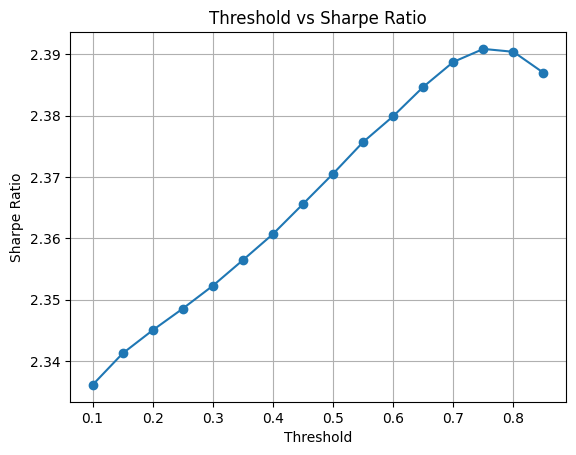

In [26]:
import matplotlib.pyplot as plt

thresholds = np.arange(0.1, 0.9, 0.05)
sharpe_list = [compute_sharpe_for_threshold(xgb_pred_all, th) for th in thresholds]

plt.plot(thresholds, sharpe_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Threshold vs Sharpe Ratio')
plt.ticklabel_format(useOffset=False)
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.arange(0.1, 0.9, 0.05)
sharpe_list = [compute_sharpe_for_threshold(cat_pred_all, th) for th in thresholds]

plt.plot(thresholds, sharpe_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Threshold vs Sharpe Ratio')
plt.ticklabel_format(useOffset=False)
plt.grid(True)
plt.show()